<a href="https://colab.research.google.com/github/rediahmds/eco-sort/blob/main/train/train-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EcoSort Machine Learning

## Prepare dataset

In [1]:
!pip install kagglehub

In [ ]:
import kagglehub


# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/waste-classification-data


In [ ]:
!ls /kaggle/input/waste-classification-data/DATASET/TRAIN

O  R


In [ ]:
from pathlib import Path
import shutil
from tqdm import tqdm
from random import sample, seed
seed(13)

original_path = Path(f"{path}/DATASET/TRAIN")
target_path = Path("dataset")
n_file = 1_000  # Jumlah file yang ingin disalin per kelas

# Mapping folder ke kelas
label_map = {
    "O": "organik",
    "R": "non_organik"
}

# Buat direktori target
for label in label_map.values():
    (target_path / label).mkdir(parents=True, exist_ok=True)

# Proses penyalinan file secara random
for subfolder, kelas in label_map.items():
    source_dir = original_path / subfolder
    dest_dir = target_path / kelas

    # Ambil semua file
    all_files = [f for f in source_dir.iterdir() if f.is_file()]
    jumlah_file_tersedia = len(all_files)

    # Ambil sample acak sejumlah n_file atau maksimal yang tersedia
    selected_files = sample(all_files, min(n_file, jumlah_file_tersedia))

    for file in tqdm(selected_files, desc=f"Copying {subfolder} -> {kelas}"):
        shutil.copy(file, dest_dir)


Copying R -> non_organik: 100%|██████████| 1000/1000 [00:04<00:00, 231.70it/s]


## Feature Extraction

In [ ]:
import cv2
import numpy as np
from pathlib import Path
from skimage.feature import local_binary_pattern

def extract_features(img_path: Path):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (128, 128))

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    return np.hstack([hist, lbp_hist])

def load_dataset(path: Path):
    X, y = [], []
    for label in ['organik', 'non_organik']:
        folder = path / label
        for file in folder.iterdir():
            if file.is_file():
                X.append(extract_features(file))
                y.append(label)
    return np.array(X), np.array(y)


## Training

Model Selection

🔎 Evaluasi awal model:
SVM Linear: Akurasi = 0.7785
SVM RBF: Akurasi = 0.8128
KNN: Akurasi = 0.8128
Random Forest: Akurasi = 0.8584

🔧 Tuning Random Forest (GridSearchCV)...
✅ Model terbaik: RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=50)
Akurasi akhir (test set): 0.8584474885844748

🧾 Classification Report:
              precision    recall  f1-score   support

 non_organik       0.87      0.83      0.85       214
     organik       0.85      0.88      0.86       224

    accuracy                           0.86       438
   macro avg       0.86      0.86      0.86       438
weighted avg       0.86      0.86      0.86       438



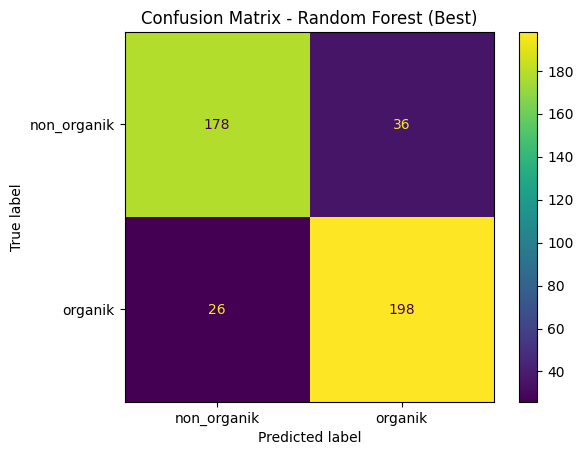

💾 Model terbaik disimpan sebagai 'model.pkl'


In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load dataset & preprocessing
X, y = load_dataset(Path("dataset"))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model kandidat
models = {
    "SVM Linear": SVC(kernel="linear"),
    "SVM RBF": SVC(kernel="rbf"),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

print("🔎 Evaluasi awal model:")
for name, model in models.items():
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"{name}: Akurasi = {acc:.4f}")

# Tuning model terbaik (contoh: Random Forest)
print("\n🔧 Tuning Random Forest (GridSearchCV)...")
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print(f"✅ Model terbaik: {grid.best_estimator_}")
print("Akurasi akhir (test set):", grid.score(X_test, y_test))

# Classification report & confusion matrix
y_pred = grid.predict(X_test)
print("\n🧾 Classification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)
plt.title("Confusion Matrix - Random Forest (Best)")
plt.show()

import joblib

# Simpan model terbaik
joblib.dump(grid.best_estimator_, "model.pkl")
print("💾 Model terbaik disimpan sebagai 'model.pkl'")
